In [ ]:
import numpy as np
import nltk
import string
import os
import pandas
import matplotlib.pyplot as plt
import profanityfilter
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, 
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from scipy.interpolate import interp1d

In [2]:
df = pandas.read_csv('merged.csv')
df_sorted = df.sort(['Year'], ascending=[1])
print(df_sorted.shape)
print(df_sorted.head())

(4988, 4)
                                          Song           Artist  Year  \
0     i cant help myself sugar pie honey bunch        four tops  1965   
4109                           it aint me babe      the turtles  1965   
4110                 red roses for a blue lady         vic dana  1965   
4111                     dont just stand there       patty duke  1965   
4112                             little things  bobby goldsboro  1965   

                                                 Lyrics  
0      Ooh, sugar pie, honey bunch\nYou know that I ...  
4109   go away from my window leave at your own chos...  
4110  vic dana miscellaneous red roses for a blue la...  
4111  please dont just stand there come and kiss me ...  
4112  little things that you do  make me glad im in ...  


/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


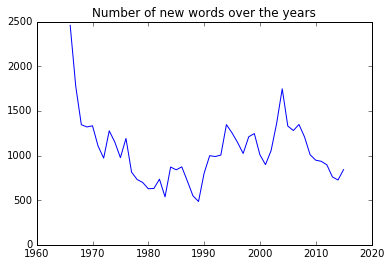

In [3]:
### Visualization
## Average number of words per year
prev_year = set()
this_year = set()
year = '1965'
diffs = []
diffs.append([])
diffs.append([])
for row in df_sorted.iterrows():
    if year != row[1]['Year']:
        intersection = this_year.intersection(prev_year)
        diffs[0].append(len(this_year)-len(intersection))
        prev_year = prev_year.union(this_year)
        this_year = set()
        year = row[1]['Year']
    for w in row[1]['Lyrics'].split():
        this_year.add(w)
        
plt.plot(range(1966, 2016), diffs[0][1:])
plt.title("Number of new words over the years")
plt.show()

R2 score: 0.26493386708


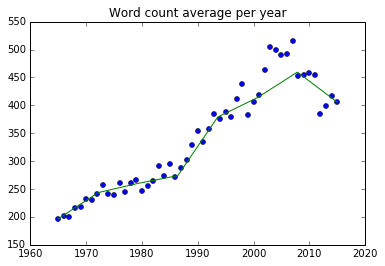

In [4]:
### Benchmark Model

# Count the number of words in each song
word_counts = [len(row[1]['Lyrics'].replace('\n', ' ').split()) for row in df_sorted.iterrows()]
X_bench = np.array(word_counts).reshape((len(word_counts), 1))
y_bench = df_sorted['Year']

# Train test split for benchmark
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.2, random_state=1)

# Initiliaze and train the benchmar model
benchmark_model = LinearRegression()
benchmark_model.fit(X_train_b, y_train_b)

# Predict year using the benchmark and print r2 score
y_pred = benchmark_model.predict(X_test_b)
print('R2 score: {}'.format(r2_score(y_test_b, y_pred)))

# Plot word count average per year
aggregations = {'Lyrics': lambda x: np.mean([len(r.replace('\n', ' ').split()) for r in x])}

word_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
x = range(1965, 2016)

# Interpolate the function
f = interp1d(np.array(x), np.array(word_count_avg_per_year).squeeze(), kind='cubic')
x_interp = np.linspace(1965, 2015, num=8, endpoint=True)

# Plot
plt.plot(x, word_count_avg_per_year, 'o', x_interp, f(x_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.title("Word count average per year")
plt.show()


In [5]:
### Vectorizing the data

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens_filtered = filter(lambda w: not w in set(stopwords.words('english')), tokens)
    stems = stem_tokens(tokens_filtered, stemmer)
    return stems

result = []

for row in df.iterrows():
    text = row[1]['Lyrics']
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    result.append(no_punctuation)

try:
    tfidf = pickle.load(open("tfidf.pickle", "rb"))
except (OSError, IOError) as e:
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', encoding='latin-1', binary=True, sublinear_tf=True)
    pickle.dump(tfidf, open("tfidf.pickle", "wb"))
    
try:
    tfs = pickle.load(open("tfs.pickle", "rb"))
except (OSError, IOError) as e:
    tfs = tfidf.fit_transform(result)
    pickle.dump(tfs, open("tfs.pickle", "wb"))

tfs.shape

(4988, 22637)

In [6]:
### Adding relevant features
profanityfilter.append_words(['skeet', 'hoe', 'hoes', 'thot', 'thots', 'niggas', 'niggaz', 'shits', 'mothafuckin'])

# Compute profanity count average per year
aggregations = {
    'Lyrics': lambda year: np.mean([sum([r.replace('\n', ' ').lower().translate(None, string.punctuation).split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in year])
}

try:
    profanity_count_avg_per_year = pickle.load(open("pcapy.pickle", "rb"))
except (OSError, IOError) as e:
    profanity_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
    pickle.dump(profanity_count_avg_per_year, open("pcapy.pickle", "wb"))

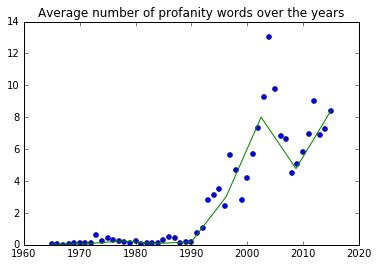

In [7]:
# Interpolate the function
f_prof = interp1d(np.array(x), np.array(profanity_count_avg_per_year).squeeze(), kind='cubic')
x_prof_interp = np.linspace(1965, 2015, num=9, endpoint=True)

# Plot profanity average per year
plt.plot(x, profanity_count_avg_per_year, 'o', x_prof_interp, f_prof(x_prof_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.title("Average number of profanity words over the years")
plt.show()

In [9]:
profanity_count = [sum([r.split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in result]
tfs_profanity = np.concatenate((np.array(profanity_exists).reshape(len(profanity_exists), 1), tfs.toarray()), axis=1)
print('Dataset with profanity: {}\n'.format(tfs_profanity.shape))

word_count_per_dp = [len(r.replace('\n', ' ').split()) for r in df['Lyrics']]
tfs_profanity_wc = np.concatenate((np.array(word_count_per_dp).reshape(len(word_count_per_dp), 1), tfs_profanity), axis=1)
print('Dataset with profanity and word count shape: {}\n'.format(tfs_profanity_wc.shape))

X_train, X_test, y_train, y_test = train_test_split(tfs_profanity_wc, df['Year']-1965, test_size=0.2, random_state=2)
print('y_train samples:')
print(y_train.head())

Dataset with profanity: (4988, 22638)

Dataset with profanity and word count shape: (4988, 22639)

y_train samples:
3526    45
1847    25
3418    43
2604    34
3643    46
Name: Year, dtype: int64


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=0)
pca.fit(tfs_profanity_wc)

print(pca.explained_variance_ratio_)

[  9.99962362e-01   4.31339564e-06   2.21085750e-07   1.41930511e-07
   1.09362879e-07   8.93347986e-08   8.64791621e-08   7.97219445e-08
   7.69079600e-08   7.36684701e-08   7.11823731e-08   6.95490464e-08
   6.78740668e-08   6.57102534e-08   6.42749355e-08   6.41822411e-08
   6.33105627e-08   6.23486649e-08   6.22218736e-08   6.09073596e-08
   6.00503357e-08   5.94946722e-08   5.91537428e-08   5.85379508e-08
   5.77966472e-08   5.71370817e-08   5.66031614e-08   5.56755471e-08
   5.53973662e-08   5.49266517e-08   5.40145316e-08   5.36739964e-08
   5.31392124e-08   5.28820910e-08   5.21465799e-08   5.19622654e-08
   5.17104855e-08   5.16637654e-08   5.12971488e-08   5.09744153e-08
   5.08235947e-08   4.98616624e-08   4.96373644e-08   4.94036738e-08
   4.90397168e-08   4.84411805e-08   4.80549001e-08   4.79125455e-08
   4.76473852e-08   4.70724629e-08]


In [11]:
print(tfs_profanity_wc)
print(pca.n_components_)
tfs_post_pca = pca.transform(tfs_profanity_wc)

X_train, X_test, y_train, y_test = train_test_split(tfs_post_pca, df['Year']-1965, test_size=0.2, random_state=2)

rf = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=300, max_features=20, verbose=2)
rf.fit(X_train, y_train)
print(rf.feature_importances_)

[[ 277.    0.    0. ...,    0.    0.    0.]
 [ 256.    0.    0. ...,    0.    0.    0.]
 [ 156.    0.    0. ...,    0.    0.    0.]
 ..., 
 [ 509.    1.    0. ...,    0.    0.    0.]
 [ 500.    1.    0. ...,    0.    0.    0.]
 [ 223.    0.    0. ...,    0.    0.    0.]]
50
building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
 building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.3s


building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300building tree 50 of 300
building tree 51 of 300

building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.9s


building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.3s finished


[ 0.24580056  0.11775572  0.02261215  0.02282315  0.01718015  0.01565229
  0.03276508  0.01359934  0.01591128  0.01115445  0.01267975  0.01026318
  0.02539569  0.02927914  0.00988467  0.01313687  0.01195593  0.01324102
  0.01089845  0.01156719  0.0136406   0.01090242  0.01107598  0.01941047
  0.01041338  0.01076688  0.0102405   0.01125189  0.01072794  0.01159518
  0.01127889  0.01080916  0.01048025  0.00979251  0.01088052  0.0117471
  0.01113031  0.01036071  0.01171354  0.01103037  0.0107862   0.01109842
  0.01158577  0.01053418  0.01032946  0.01020111  0.01019893  0.00998337
  0.01178766  0.01069021]


In [12]:
rf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


0.46324752976695094

In [19]:
def fit_model(X, y, params):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    
    regressor = MLPRegressor(random_state=1, learning_rate='adaptive', alpha=0.00001)
    scoring_fnc = make_scorer(r2_score)
    
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets, verbose=2)
    grid = grid.fit(X, y)
    
    return grid.best_estimator_

In [20]:
best_model = fit_model(X_train, y_train, {'hidden_layer_sizes': [(10,), (50,), (100,), (50,10)], 'max_iter':[100, 200, 500, 1000]})

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.8s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.7s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.6s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.6s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.7s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.6s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.6s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] ................. max_iter=100, hidden_layer_sizes=(10,) -   0.7s
[CV] max_iter=100, hidden_layer_sizes=(10,) ..........................
[CV] .

[CV] ................. max_iter=200, hidden_layer_sizes=(50,) -   2.4s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.6s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.0s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.2s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.3s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.1s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] ................. max_iter=500, hidden_layer_sizes=(50,) -   2.1s
[CV] max_iter=500, hidden_layer_sizes=(50,) ..........................
[CV] .

[CV] ............... max_iter=1000, hidden_layer_sizes=(100,) -   1.0s
[CV] max_iter=1000, hidden_layer_sizes=(100,) ........................
[CV] ............... max_iter=1000, hidden_layer_sizes=(100,) -   1.3s
[CV] max_iter=1000, hidden_layer_sizes=(100,) ........................
[CV] ............... max_iter=1000, hidden_layer_sizes=(100,) -   1.2s
[CV] max_iter=100, hidden_layer_sizes=(50, 10) .......................
[CV] .............. max_iter=100, hidden_layer_sizes=(50, 10) -   0.8s
[CV] max_iter=100, hidden_layer_sizes=(50, 10) .......................
[CV] .............. max_iter=100, hidden_layer_sizes=(50, 10) -   0.9s
[CV] max_iter=100, hidden_layer_sizes=(50, 10) .......................
[CV] .............. max_iter=100, hidden_layer_sizes=(50, 10) -   0.9s
[CV] max_iter=100, hidden_layer_sizes=(50, 10) .......................
[CV] .............. max_iter=100, hidden_layer_sizes=(50, 10) -   1.0s
[CV] max_iter=100, hidden_layer_sizes=(50, 10) .......................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.7min finished


In [21]:
print(best_model.score(X_test, y_test))

0.466443788784


In [22]:
print(best_model)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)


(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)


(4988, 2)


((3990, 2), (998, 2), (3990,), (998,))


R2 score: -2124.96137587
